In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
import numpy as np
import skimage
import random
from tensorflow.keras.optimizers import Adam
import Denoise_layer # The custom built CVXPY layer
import matplotlib.pyplot as plt

In [3]:
#Getting the MNIST dataset
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape #Shapes of the variables

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
#number of samples taken
train_num = 10000
test_num = 2000

In [6]:
#slicing the data
x_train = x_train[:train_num]
y_train = y_train[:train_num]
x_test = x_test[:test_num]
y_test = y_test[:test_num]

In [7]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((10000, 28, 28), (10000,), (2000, 28, 28), (2000,))

In [8]:
y_test.shape

(2000,)

In [9]:
#Finding total number of images in training and test set
print(len(x_train))
print(len(x_test))

10000
2000


In [10]:
#normalizing the entire data
x_train = x_train/255.0
x_test = x_test/255.0

In [11]:
#Reshaping and Normalizing training and test images
x_train = x_train.reshape(train_num, 28, 28, 1)

x_test = x_test.reshape(test_num, 28, 28, 1)


In [12]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((10000, 28, 28, 1), (10000,), (2000, 28, 28, 1), (2000,))

In [13]:
epochs = 10
batchSize = 32
opt = Adam(learning_rate=0.001)

In [14]:
#VGG model Building using Keras
def VGG16model():
  model = Sequential()

  model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(28, 28, 1)))
  model.add(Conv2D(64, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  return model

In [15]:
#The instance for the cvxpy layer
def CVXPYmodel(inp_shape, lam):
    
    denoise = Denoise_layer.Denoise(input_shape=inp_shape,lam_val=lam,trainable=False)
    model = Sequential()
    model.add(denoise)
    model.compile()
    
    return model 

In [16]:
from sklearn.metrics import classification_report,confusion_matrix

### Model-8
+ Noise level= 0.7

In [17]:
import skimage
import matplotlib.pyplot as plt

In [18]:
#Adding noise to the dataset with the level
import skimage
noise_lvl_3 = 0.7
noise_x_train_3 = np.array([skimage.util.random_noise(x, mode='gaussian', seed=42, clip=True, var = noise_lvl_3)  for x in x_train])
noise_x_test_3 = np.array([skimage.util.random_noise(x, mode='gaussian', seed=42, clip=True, var = noise_lvl_3) for x in x_test])

In [19]:
model_8 = VGG16model()

In [20]:
history_8 = model_8.fit(noise_x_train_3, y_train, epochs = epochs, batch_size = batchSize)#training the model

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/10
313/313 [==============================] - 23s 44ms/step - loss: 1.6202 - accuracy: 0.5889
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 0.4642 - accuracy: 0.8684
Epoch 3/10
313/313 [==============================] - 10s 32ms/step - loss: 0.3273 - accuracy: 0.9104
Epoch 4/10
313/313 [==============================] - 10s 33ms/step - loss: 0.3423 - accuracy: 0.9128
Epoch 5/10
313/313 [==============================] - 11s 34ms/step - loss: 0.3528 - accuracy: 0.9188
Epoch 6/10
313/313 [==============================] - 10s 32ms/step - loss: 0.3149 - accuracy: 0.9259
Epoch 7/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2630 - accuracy: 0.9381
Epoch 8/10
313/313 [==============================] - 10s 32ms/step - loss: 0.2316 - accuracy: 0.9463
Epoch 9/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1345 - accuracy: 0.9682
Epoch 10/10
313/313 [==============================] - 10s 33ms/step - loss: 0.148

In [21]:
#Function for showing the accuracy and loss plots
def ShowPlots(hist):
  plt.figure(figsize=(16,6))
  plt.subplot(121)
  plt.plot(hist.history["accuracy"],'-ro',label="Accuracy")
  #plt.plot(hist.history["val_accuracy"],'-bo',label="Validation Accuracy")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.subplot(122)
  plt.plot(hist.history["loss"],'-ro',label="Loss")
  #plt.plot(hist.history["val_loss"],'-bo',label="Validation Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  return plt.show()

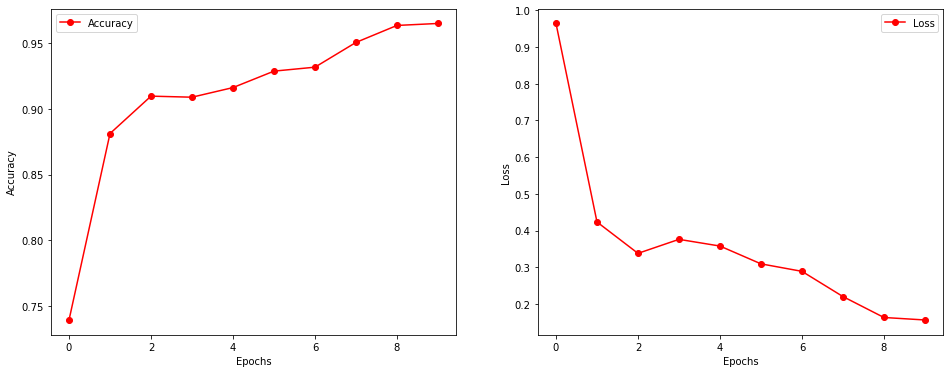

In [22]:
ShowPlots(history_8)

In [23]:
y_pred_8 = model_8.predict(noise_x_test_3)
y_pred_8 = np.argmax(y_pred_8,axis=1)

In [24]:
confusion_matrix(y_test,y_pred_8)

array([[156,   2,   9,   0,   2,   1,   1,   3,   1,   0],
       [  0, 232,   0,   2,   0,   0,   0,   0,   0,   0],
       [  1,  13, 195,   7,   0,   0,   2,   0,   1,   0],
       [  0,   0,   0, 204,   0,   3,   0,   0,   0,   0],
       [  0,   6,   1,   0, 184,   0,   4,   7,   0,  15],
       [  0,   0,   0,   1,   0, 176,   0,   2,   0,   0],
       [  3,   0,   0,   0,   0,   9, 165,   0,   1,   0],
       [  0,   8,   6,  30,   0,   0,   0, 159,   0,   2],
       [  1,   4,   2,   8,   0,   5,   0,   1, 165,   6],
       [  0,   6,   0,   3,   1,   3,   0,   1,   2, 178]], dtype=int64)

In [25]:
print(classification_report(y_test,y_pred_8))#classification report

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       175
           1       0.86      0.99      0.92       234
           2       0.92      0.89      0.90       219
           3       0.80      0.99      0.88       207
           4       0.98      0.85      0.91       217
           5       0.89      0.98      0.94       179
           6       0.96      0.93      0.94       178
           7       0.92      0.78      0.84       205
           8       0.97      0.86      0.91       192
           9       0.89      0.92      0.90       194

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



### Model-9
+ noise level = 0.7
+ lamda value = 0.2

In [26]:
cvxpy_layer_1 = CVXPYmodel((28,28),0.2)#making the cvxpy model

In [27]:
denoised_train_1 = cvxpy_layer_1.predict(noise_x_train_3.reshape(train_num,28,28)) #Denoising the input images

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [28]:
denoised_train_1.shape

(10000, 28, 28, 1)

In [29]:
model_9 = VGG16model()

In [31]:
history_9 = model_9.fit(denoised_train_1,y_train,epochs= epochs,batch_size= batchSize)#training the model with the denoised data

Epoch 1/10
313/313 [==============================] - 10s 33ms/step - loss: 7.4781 - accuracy: 0.1830
Epoch 2/10
313/313 [==============================] - 10s 33ms/step - loss: 1.4842 - accuracy: 0.4353
Epoch 3/10
313/313 [==============================] - 11s 34ms/step - loss: 1.0934 - accuracy: 0.5809
Epoch 4/10
313/313 [==============================] - 11s 34ms/step - loss: 0.9214 - accuracy: 0.6719
Epoch 5/10
313/313 [==============================] - 11s 34ms/step - loss: 0.7788 - accuracy: 0.7394
Epoch 6/10
313/313 [==============================] - 11s 34ms/step - loss: 0.7802 - accuracy: 0.7619
Epoch 7/10
313/313 [==============================] - 11s 34ms/step - loss: 0.6542 - accuracy: 0.7964
Epoch 8/10
313/313 [==============================] - 10s 33ms/step - loss: 0.7216 - accuracy: 0.7929
Epoch 9/10
313/313 [==============================] - 10s 33ms/step - loss: 0.4770 - accuracy: 0.8631
Epoch 10/10
313/313 [==============================] - 10s 33ms/step - loss: 0.444

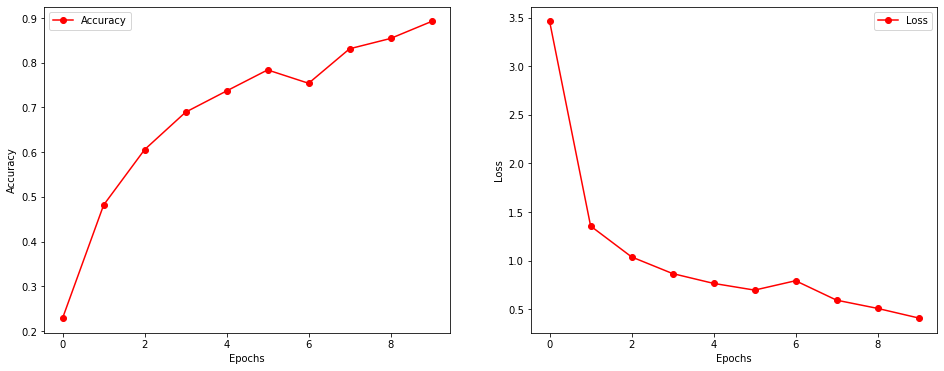

In [32]:
ShowPlots(history_9)

In [33]:
denoised_test_1 = cvxpy_layer_1.predict(noise_x_test_3.reshape(test_num,28,28))#Denoising the input images

In [34]:
denoised_test_1.shape

(2000, 28, 28, 1)

In [36]:
y_pred_9 = model_9.predict(denoised_test_1) #Predicting the denoised test data
y_pred_9 = np.argmax(y_pred_9,axis=1)

In [37]:
confusion_matrix(y_test,y_pred_9)

array([[170,   0,   0,   0,   0,   1,   0,   0,   4,   0],
       [  0, 230,   1,   0,   0,   2,   1,   0,   0,   0],
       [  1,   0, 195,  18,   0,   4,   0,   0,   1,   0],
       [  0,   0,   3, 203,   0,   1,   0,   0,   0,   0],
       [  1,   4,   0,   0, 191,   1,   3,   2,   7,   8],
       [  2,   0,   2,   8,   0, 165,   0,   0,   2,   0],
       [ 18,   1,   0,   0,   0,  13, 142,   0,   4,   0],
       [  0,   1,  16,   2,   1,   0,   0, 183,   0,   2],
       [  7,   0,   1,  12,   0,   1,   0,   0, 170,   1],
       [  0,   0,   0,  12,   5,   1,   0,  11,  28, 137]], dtype=int64)

In [39]:
print(classification_report(y_test,y_pred_9))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       175
           1       0.97      0.98      0.98       234
           2       0.89      0.89      0.89       219
           3       0.80      0.98      0.88       207
           4       0.97      0.88      0.92       217
           5       0.87      0.92      0.90       179
           6       0.97      0.80      0.88       178
           7       0.93      0.89      0.91       205
           8       0.79      0.89      0.83       192
           9       0.93      0.71      0.80       194

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



In [40]:
import math 
import numpy as np 
#function for calculating the PSNR value
def calculate_psnr(img1, img2): 
    # img1 and img2 have range [0, 255] 
    img1 = img1.astype(np.float64) 
    img2 = img2.astype(np.float64) 
    mse = np.mean((img1 - img2)**2) 
    if mse == 0:
        return float('inf') 
    return 20 * math.log10(1.0 / math.sqrt(mse))

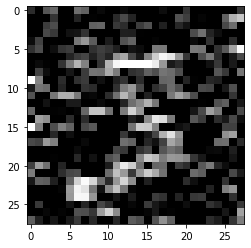

In [41]:
plt.imshow(denoised_train_1[0],cmap='gray')

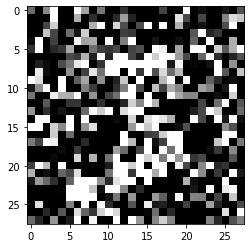

In [43]:
plt.imshow(noise_x_train_3[0],cmap='gray')

In [44]:
calculate_psnr(x_train[0],denoised_train_1[0])#1

11.063712322966099

In [45]:
calculate_psnr(x_train[0],noise_x_train_3[0]) #1

7.042397811651178

In [46]:
psnr_denoised_1 = 0
for i,j in zip(x_train,denoised_train_1):
    psnr_denoised_1 = calculate_psnr(i,j) + psnr_denoised_1
psnr_denoised_1 = psnr_denoised_1/x_train.shape[0]
psnr_denoised_1

10.639907909737769

In [47]:
psnr_noised_1 = 0
for i,j in zip(x_train,noise_x_train_3):
    psnr_noised_1 = calculate_psnr(i,j) + psnr_noised_1
psnr_noised_1 = psnr_noised_1/x_train.shape[0]
psnr_noised_1

6.863497014718605

### Model-10
+ noise level = 0.7
+ lambda value = 0.5

In [48]:
cvxpy_layer_2 = CVXPYmodel((28,28),0.5) #instance for cvxpy model

In [49]:
denoised_train_2 = cvxpy_layer_2.predict(noise_x_train_3.reshape(train_num,28,28)) #Denoising the input images

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [50]:
model_10 = VGG16model()

In [51]:
history_10 = model_10.fit(denoised_train_2,y_train,epochs= epochs,batch_size= batchSize)#training with the denoised images

Epoch 1/10
313/313 [==============================] - 11s 34ms/step - loss: 8.4097 - accuracy: 0.1088
Epoch 2/10
313/313 [==============================] - 11s 35ms/step - loss: 2.3037 - accuracy: 0.1136
Epoch 3/10
313/313 [==============================] - 11s 35ms/step - loss: 2.3023 - accuracy: 0.1112
Epoch 4/10
313/313 [==============================] - 10s 33ms/step - loss: 2.2743 - accuracy: 0.1389
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 1.9292 - accuracy: 0.2388
Epoch 6/10
313/313 [==============================] - 10s 33ms/step - loss: 1.6952 - accuracy: 0.3297
Epoch 7/10
313/313 [==============================] - 10s 33ms/step - loss: 1.5131 - accuracy: 0.4191
Epoch 8/10
313/313 [==============================] - 11s 34ms/step - loss: 1.2400 - accuracy: 0.5543
Epoch 9/10
313/313 [==============================] - 11s 34ms/step - loss: 0.9770 - accuracy: 0.6549
Epoch 10/10
313/313 [==============================] - 11s 34ms/step - loss: 0.771

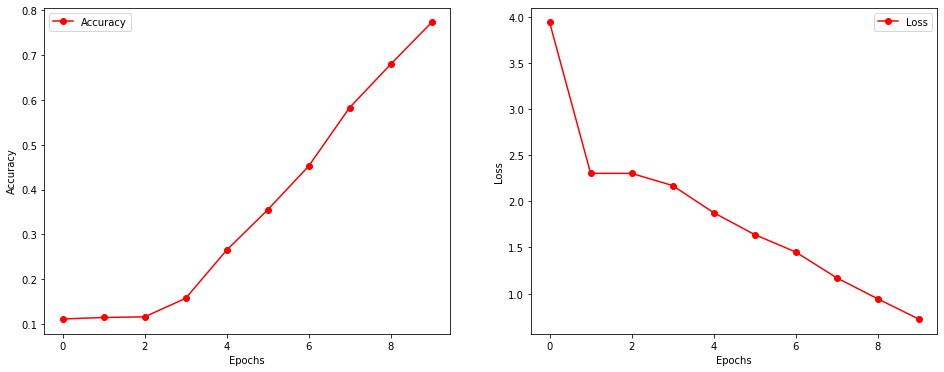

In [52]:
ShowPlots(history_10)

In [54]:
denoised_test_2 = cvxpy_layer_2.predict(noise_x_test_3.reshape(test_num,28,28)) #Denoising the input images-test

In [55]:
y_pred_10 = model_10.predict(denoised_test_2)#Predicting the denoised test data
y_pred_10 = np.argmax(y_pred_10,axis=1)

In [56]:
confusion_matrix(y_test,y_pred_10)#confusion matrix

array([[133,   0,   3,  14,   0,   9,   0,   1,  15,   0],
       [  0, 231,   0,   0,   0,   1,   0,   0,   2,   0],
       [ 23,  26, 110,   4,   0,   5,   2,   2,  47,   0],
       [  0,   3,   0,  65,   0, 121,   0,   6,  12,   0],
       [  0,   6,   8,   0, 130,   0,   9,  23,  30,  11],
       [  1,   7,   0,   2,   0, 130,   0,   5,  31,   3],
       [  0,  13,  13,   0,   0,   2, 125,   1,  24,   0],
       [  0,  14,   0,   0,   0,   3,   0, 181,   4,   3],
       [  1,  11,   1,   1,   0, 105,   1,   2,  67,   3],
       [  2,   1,   0,   0,   2,  25,   0,  73,   9,  82]], dtype=int64)

In [57]:
print(classification_report(y_test,y_pred_10))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       175
           1       0.74      0.99      0.85       234
           2       0.81      0.50      0.62       219
           3       0.76      0.31      0.44       207
           4       0.98      0.60      0.74       217
           5       0.32      0.73      0.45       179
           6       0.91      0.70      0.79       178
           7       0.62      0.88      0.73       205
           8       0.28      0.35      0.31       192
           9       0.80      0.42      0.55       194

    accuracy                           0.63      2000
   macro avg       0.71      0.62      0.63      2000
weighted avg       0.71      0.63      0.63      2000



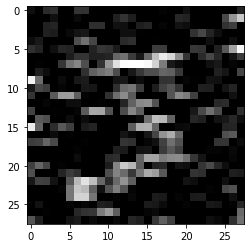

In [58]:
plt.imshow(denoised_train_2[0],cmap='gray')#denoised image

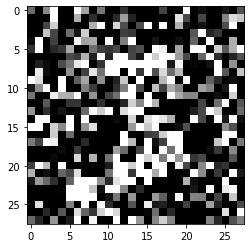

In [60]:
plt.imshow(noise_x_train_3[0],cmap='gray')#noise image

In [61]:
calculate_psnr(x_train[0],denoised_train_2[0])#1

11.645050707462339

In [62]:
calculate_psnr(x_train[0],noise_x_train_3[0])

7.042397811651178

In [68]:
psnr_denoised_1 = 0
for i,j in zip(x_train,denoised_train_2):
    psnr_denoised_1 = calculate_psnr(i,j) + psnr_denoised_1
psnr_denoised_1 = psnr_denoised_1/x_train.shape[0]
psnr_denoised_1

11.275696184066161

In [64]:
psnr_noised_1 = 0
for i,j in zip(x_train,noise_x_train_3):
    psnr_noised_1 = calculate_psnr(i,j) + psnr_noised_1
psnr_noised_1 = psnr_noised_1/x_train.shape[0]
psnr_noised_1

6.863497014718605

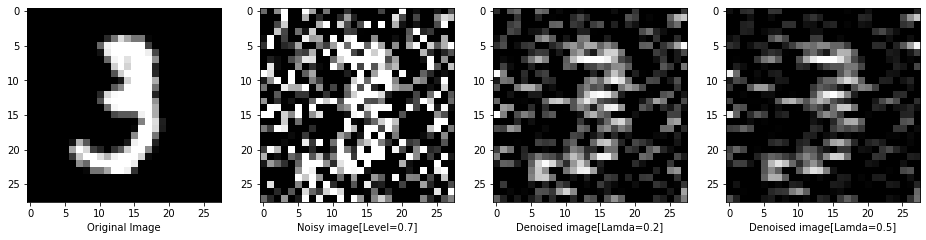

In [67]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 4, 1)
plt.imshow(x_train[10].reshape(28,28),cmap='gray')
plt.xlabel("Original Image")
plt.subplot(1, 4, 2)
plt.imshow(noise_x_train_3[10].reshape(28,28),cmap='gray')
plt.xlabel("Noisy image[Level=0.7]")
plt.subplot(1, 4, 3)
plt.imshow(denoised_train_1[10].reshape(28,28),cmap='gray')
plt.xlabel("Denoised image[Lamda=0.2]")
plt.subplot(1, 4, 4)
plt.imshow(denoised_train_2[10].reshape(28,28),cmap='gray')
plt.xlabel("Denoised image[Lamda=0.5]")
plt.show()